In [1]:
%load_ext lab_black

In [2]:
import pandas as pd

from matplotlib import pyplot as plt
import numpy as np

# from sklearn.tree import export_graphviz
# from sklearn.externals.six import StringIO
# from IPython.display import Image
# import pydotplus

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

import joblib

In [3]:
# read in data
df = pd.read_csv("heart_disease_data.csv")

In [4]:
# df.columns
df.dtypes

age            int64
sex            int64
cp             int64
trestbps       int64
chol           int64
fbs            int64
restecg        int64
thalach        int64
exang          int64
oldpeak      float64
slope          int64
ca             int64
thal           int64
condition      int64
dtype: object

In [5]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [6]:
# drop unused columns
df = (
    df.drop("restecg", axis=1)
    .drop("oldpeak", axis=1)
    .drop("slope", axis=1)
    .drop("ca", axis=1)
    .drop("thal", axis=1)
)
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'thalach', 'exang',
       'condition'],
      dtype='object')

In [7]:
df["condition"].value_counts()

0    160
1    137
Name: condition, dtype: int64

In [8]:
# rename condition
# df = df.assign(
#     exang=lambda df: df["condition"].replace(
#         {0: "No Heart Disease", 1: "Yes Heart Disease"}
#     )
# )

In [9]:
# rename exang: exercise induced angina (1 = yes; 0 = no)
df = df.assign(exang=lambda df: df["exang"].replace({0: "no", 1: "yes"}))

In [10]:
# rename fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
df = df.assign(fbs=lambda df: df["fbs"].replace({0: "false", 1: "true"}))

In [11]:
# rename cp: chest pain type
df = df.assign(
    cp=lambda df: df["cp"].replace(
        {
            0: "typical angina",
            1: "atypical angina",
            2: "non-anginal pain",
            3: "asymptomatic",
        }
    )
)

In [12]:
target = "condition"

In [13]:
y = df[target].values
X = df.drop(target, axis=1)

In [14]:
y

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1])

In [15]:
X.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'thalach', 'exang'], dtype='object')

In [16]:
cf = ColumnTransformer(
    [
        ("numerical", "passthrough", ["age", "trestbps", "chol", "thalach"],),
        ('"categorical"', OneHotEncoder(drop="first"), ["sex", "cp", "fbs", "exang"]),
    ]
)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [18]:
# Dummy Classifier

d_pipeline = make_pipeline(cf, DummyClassifier())
d_pipeline.fit(X_train, y_train)
y_test_pred_dc = d_pipeline.predict(X_test)
print(classification_report(y_test, y_test_pred_dc))

              precision    recall  f1-score   support

           0       0.53      1.00      0.70        40
           1       0.00      0.00      0.00        35

    accuracy                           0.53        75
   macro avg       0.27      0.50      0.35        75
weighted avg       0.28      0.53      0.37        75



/home/jupyter/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
# accuracy score for Dummy Classifier

accuracy_score(y_test, y_test_pred_dc)

0.5333333333333333

In [52]:
# Logistic Regression Model

lr_pipeline = make_pipeline(cf, LogisticRegression(max_iter=1000))
lr_pipeline.fit(X_train, y_train)
y_test_pred_lr = lr_pipeline.predict(X_test)
print(classification_report(y_test, y_test_pred_lr))

              precision    recall  f1-score   support

           0       0.76      0.85      0.80        40
           1       0.80      0.69      0.74        35

    accuracy                           0.77        75
   macro avg       0.78      0.77      0.77        75
weighted avg       0.78      0.77      0.77        75



In [21]:
# accuracy score for Logistic Regression Model

accuracy_score(y_test, y_test_pred_lr)

0.7733333333333333

In [22]:
# Decision Tree Model (unpruned)

dt_pipeline = make_pipeline(cf, DecisionTreeClassifier())
dt_pipeline.fit(X_train, y_train)
y_test_pred_dt = dt_pipeline.predict(X_test)
print(classification_report(y_test, y_test_pred_dt))

              precision    recall  f1-score   support

           0       0.65      0.75      0.70        40
           1       0.66      0.54      0.59        35

    accuracy                           0.65        75
   macro avg       0.65      0.65      0.65        75
weighted avg       0.65      0.65      0.65        75



In [23]:
# accuracy score for decision tree model (unpruned)

accuracy_score(y_test, y_test_pred_dt)

0.6533333333333333

In [24]:
# Unpruned Tree

# dot_data = StringIO()
# export_graphviz(dt, out_file=dot_data)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
# graph.write_png("tree.png")
# Image(graph.create_png())

In [25]:
# Prune the tree - gini

dt_pipeline_p1 = make_pipeline(cf, DecisionTreeClassifier(criterion="gini"))
dt_pipeline_p1.fit(X_train, y_train)
y_test_pred_dt_p1 = dt_pipeline_p1.predict(X_test)
print("Criterion=gini", classification_report(y_test, y_test_pred_dt_p1))

Criterion=gini               precision    recall  f1-score   support

           0       0.67      0.65      0.66        40
           1       0.61      0.63      0.62        35

    accuracy                           0.64        75
   macro avg       0.64      0.64      0.64        75
weighted avg       0.64      0.64      0.64        75



In [26]:
# accuracy score for decision tree model using gini

accuracy_score(y_test, y_test_pred_dt_p1)

0.64

In [27]:
# Prune the tree - entropy

dt_pipeline_p2 = make_pipeline(cf, DecisionTreeClassifier(criterion="entropy"))
dt_pipeline_p2.fit(X_train, y_train)
y_test_pred_dt_p2 = dt_pipeline_p2.predict(X_test)
print("Criterion=entropy", classification_report(y_test, y_test_pred_dt_p2))

Criterion=entropy               precision    recall  f1-score   support

           0       0.66      0.68      0.67        40
           1       0.62      0.60      0.61        35

    accuracy                           0.64        75
   macro avg       0.64      0.64      0.64        75
weighted avg       0.64      0.64      0.64        75



In [28]:
# accuracy score for decision tree model using entropy

accuracy_score(y_test, y_test_pred_dt_p2)

0.64

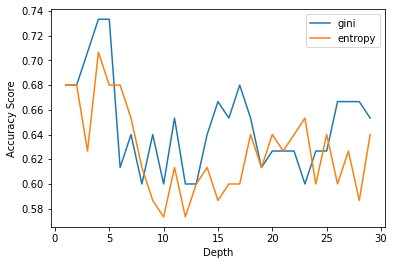

In [29]:
# Prune the tree - loop to find best depth

max_depth_dt = []
acc_gini_dt = []
acc_entropy_dt = []
for i in range(1, 30):
    dt_pipeline_p3 = make_pipeline(
        cf, DecisionTreeClassifier(criterion="gini", max_depth=i)
    )
    dt_pipeline_p3.fit(X_train, y_train)
    pred_g_dt = dt_pipeline_p3.predict(X_test)
    acc_gini_dt.append(accuracy_score(y_test, pred_g_dt))

    dt_pipeline_p4 = make_pipeline(
        cf, DecisionTreeClassifier(criterion="entropy", max_depth=i)
    )
    dt_pipeline_p4.fit(X_train, y_train)
    pred_e_dt = dt_pipeline_p4.predict(X_test)
    acc_entropy_dt.append(accuracy_score(y_test, pred_e_dt))

    max_depth_dt.append(i)

df_dt = pd.DataFrame(
    {
        "acc_gini_dt": pd.Series(acc_gini_dt),
        "acc_entropy_dt": pd.Series(acc_entropy_dt),
        "max_depth_dt": pd.Series(max_depth_dt),
    }
)

# visualizing changes in parameters
plt.plot("max_depth_dt", "acc_gini_dt", data=df_dt, label="gini")
plt.plot("max_depth_dt", "acc_entropy_dt", data=df_dt, label="entropy")
plt.xlabel("Depth")
plt.ylabel("Accuracy Score")
plt.legend()

In [30]:
# Prune tree at 5 using gini

dt_p_fin = make_pipeline(cf, DecisionTreeClassifier(criterion="gini", max_depth=5))
dt_p_fin.fit(X_train, y_train)
y_test_pred_dt_p_fin = dt_p_fin.predict(X_test)
print("Criterion=gini", classification_report(y_test, y_test_pred_dt_p_fin))

Criterion=gini               precision    recall  f1-score   support

           0       0.80      0.70      0.75        40
           1       0.70      0.80      0.75        35

    accuracy                           0.75        75
   macro avg       0.75      0.75      0.75        75
weighted avg       0.75      0.75      0.75        75



In [31]:
# accuracy score for decision tree model pruned at 5 using gini

accuracy_score(y_test, y_test_pred_dt_p_fin)

0.7466666666666667

In [32]:
# Graphic for decision tree model pruned at 5 using gini

# dot_data = StringIO()
# export_graphviz(dt_p_fin, out_file=dot_data)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
# graph.write_png("tree.png")
# Image(graph.create_png())

In [60]:
# Random Forest Model

rf_pipeline = make_pipeline(cf, RandomForestClassifier(n_estimators=10000))
rf_pipeline.fit(X_train, y_train)
y_test_pred_rf = rf_pipeline.predict(X_test)
print(classification_report(y_test, y_test_pred_rf))

              precision    recall  f1-score   support

           0       0.74      0.80      0.77        40
           1       0.75      0.69      0.72        35

    accuracy                           0.75        75
   macro avg       0.75      0.74      0.74        75
weighted avg       0.75      0.75      0.75        75



In [61]:
# accuracy score for random forest model (unpruned)

accuracy_score(y_test, y_test_pred_rf)

0.7466666666666667

In [66]:
# Prune the forest - gini

rf_pipeline_p1 = make_pipeline(
    cf, RandomForestClassifier(n_estimators=10000, criterion="gini")
)
rf_pipeline_p1.fit(X_train, y_train)
y_test_pred_rf_p1 = rf_pipeline_p1.predict(X_test)
print("Criterion=gini", classification_report(y_test, y_test_pred_rf_p1))

Criterion=gini               precision    recall  f1-score   support

           0       0.74      0.80      0.77        40
           1       0.75      0.69      0.72        35

    accuracy                           0.75        75
   macro avg       0.75      0.74      0.74        75
weighted avg       0.75      0.75      0.75        75



In [67]:
# accuracy score for random forest model using gini

accuracy_score(y_test, y_test_pred_rf_p1)

0.7466666666666667

In [68]:
# Prune the forest - entropy

rf_pipeline_p2 = make_pipeline(
    cf, RandomForestClassifier(n_estimators=10000, criterion="entropy")
)
rf_pipeline_p2.fit(X_train, y_train)
y_test_pred_rf_p2 = rf_pipeline_p2.predict(X_test)
print("Criterion=entropy", classification_report(y_test, y_test_pred_rf_p2))

Criterion=entropy               precision    recall  f1-score   support

           0       0.75      0.82      0.79        40
           1       0.77      0.69      0.73        35

    accuracy                           0.76        75
   macro avg       0.76      0.76      0.76        75
weighted avg       0.76      0.76      0.76        75



In [69]:
# accuracy score for random forest model using entropy

accuracy_score(y_test, y_test_pred_rf_p2)

0.76

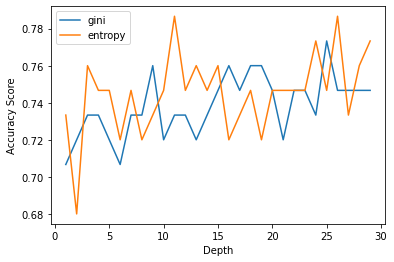

In [39]:
# # Prune the forest - loop to find best depth

# max_depth_rf = []
# acc_gini_rf = []
# acc_entropy_rf = []
# for i in range(1, 30):
#     rf_pipeline_p3 = make_pipeline(
#         cf, RandomForestClassifier(criterion="gini", max_depth=i)
#     )
#     rf_pipeline_p3.fit(X_train, y_train)
#     pred_g_rf = rf_pipeline_p3.predict(X_test)
#     acc_gini_rf.append(accuracy_score(y_test, pred_g_rf))

#     rf_pipeline_p4 = make_pipeline(
#         cf, RandomForestClassifier(criterion="entropy", max_depth=i)
#     )
#     rf_pipeline_p4.fit(X_train, y_train)
#     pred_e_rf = rf_pipeline_p4.predict(X_test)
#     acc_entropy_rf.append(accuracy_score(y_test, pred_e_rf))

#     max_depth_rf.append(i)

# df_rf = pd.DataFrame(
#     {
#         "acc_gini_rf": pd.Series(acc_gini_rf),
#         "acc_entropy_rf": pd.Series(acc_entropy_rf),
#         "max_depth_rf": pd.Series(max_depth_rf),
#     }
# )

# # visualizing changes in parameters
# plt.plot("max_depth_rf", "acc_gini_rf", data=df_rf, label="gini")
# plt.plot("max_depth_rf", "acc_entropy_rf", data=df_rf, label="entropy")
# plt.xlabel("Depth")
# plt.ylabel("Accuracy Score")
# plt.legend()

In [40]:
# # Prune forest using entropy at 14

# rf_p_fin = make_pipeline(cf, RandomForestClassifier(criterion="entropy", max_depth=14))
# rf_p_fin.fit(X_train, y_train)
# y_test_pred_rf_p_fin = rf_p_fin.predict(X_test)
# print("Criterion=entropy", classification_report(y_test, y_test_pred_rf_p_fin))

Criterion=entropy               precision    recall  f1-score   support

           0       0.74      0.80      0.77        40
           1       0.75      0.69      0.72        35

    accuracy                           0.75        75
   macro avg       0.75      0.74      0.74        75
weighted avg       0.75      0.75      0.75        75



In [41]:
# # accuracy score for  forest using entropy at 14

# accuracy_score(y_test, y_test_pred_rf_p_fin)

0.7466666666666667

In [53]:
lr_pipeline.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['age', 'trestbps', 'chol',
                                                   'thalach']),
                                                 ('"categorical"',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex', 'cp', 'fbs',
                                                   'exang'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [43]:
# lr_pipeline.predict([[65, 0, 3, 110, 264, 1, 131, 1]])[0]

In [44]:
# joblib.dump(lr_pipeline, "clf.joblib")